In [2]:
import pm4py
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())
os.chdir('/home/vco/Projects/pm4py-dcr') # working directory should be pm4py-dcr (the one behind notebooks)
print(os.getcwd())

os.environ['PM4PY_SHOW_EVENT_LOG_DEPRECATION'] = 'false'

import numpy as np
np.seterr(divide = 'ignore')

import pm4py
import datetime as dt
import pandas as pd
from copy import deepcopy
from pm4py.algo.discovery.dcr_discover import algorithm as alg
from pm4py.objects.dcr.exporter import exporter as dcr_exporter
from pm4py.objects.dcr.exporter import exporter
from pm4py.algo.evaluation.dcr.algorithm import *
from pm4py.algo.discovery.dcr_discover import algorithm
from pm4py.objects.dcr.obj import dcr_template
from pm4py.algo.evaluation.dcr import algorithm as eval_dcr_on_pdc
from pm4py.util.benchmarking import benchmark_event_log_from_configs
from pm4py.algo.discovery.dcr_discover.algorithm import Variants

pm4py.util.constants.SHOW_EVENT_LOG_DEPRECATION = False
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

/home/vco/Projects/pm4py-dcr/notebooks_projects
/home/vco/Projects/pm4py-dcr


# Meaning of prefix letters:
* A = Application
* O = Offer
* W = Workflow

# BPIC 12

In [44]:
bpic12 = pm4py.read_xes('/home/vco/Datasets/BPI_Challenge_2012.xes')
bpic12['case:AMOUNT_REQ'] = pd.to_numeric(bpic12['case:AMOUNT_REQ'])
bpic12['concept:name'].replace({'W_Completeren aanvraag':'W_Add information to application',
 'W_Nabellen offertes':'W_Follow up by phone on quotes',
 'W_Valideren aanvraag':'W_Validate application',
 'W_Wijzigen contractgegevens':'W_Change contract details',
 'W_Afhandelen leads':'W_Follow up on leads',
 'W_Nabellen incomplete dossiers':'W_Follow up by phone on incomplete case files',
 'W_Beoordelen fraude':'W_Assess fraud'},inplace=True)
bpic12['EventOrigin'] = bpic12['concept:name'].apply(lambda x: str(x).split('_')[0])

In [43]:
cancelled_cids = set(bpic12[(bpic12['lifecycle:transition']=='COMPLETE')&(bpic12['concept:name']=='A_CANCELLED')]['case:concept:name'].unique())

In [45]:
only_offer_cids = set(bpic12[bpic12['EventOrigin']=='O']['case:concept:name'].unique())

In [46]:
cancelled_no_offer_cids = cancelled_cids.difference(only_offer_cids)

In [47]:
cancelled_bpic12 = bpic12[bpic12['case:concept:name'].isin(cancelled_no_offer_cids)]

In [50]:
bpic12[(bpic12['EventOrigin']=='A')&(bpic12['lifecycle:transition']!='COMPLETE')]

Empty DataFrame
Columns: [org:resource, lifecycle:transition, concept:name, time:timestamp, case:REG_DATE, case:concept:name, case:AMOUNT_REQ, EventOrigin]
Index: []

In [49]:
bpic12_lct = deepcopy(cancelled_bpic12)
bpic12_lct['concept:name'] = bpic12_lct['concept:name'] + "_" + bpic12_lct['lifecycle:transition']
pm4py.write_xes(bpic12_lct[bpic12_lct['lifecycle:transition']!='SCHEDULE'], file_path='datasets/bpic12_no_schedule_lct_cancelled')

exporting log, completed traces :: 100%|██████████| 1167/1167 [00:00<00:00, 3054.25it/s]


In [34]:
bpic12_lct = deepcopy(bpic12)
bpic12_lct['concept:name'] = bpic12_lct['concept:name'] + "_" + bpic12_lct['lifecycle:transition']
pm4py.write_xes(bpic12_lct[bpic12_lct['lifecycle:transition']!='SCHEDULE'], file_path='datasets/bpic12_no_schedule_lct')

exporting log, completed traces :: 100%|██████████| 13087/13087 [00:03<00:00, 3445.30it/s]


In [23]:
bpic12_only_complete = bpic12[bpic12['lifecycle:transition']=='COMPLETE']

In [24]:
pm4py.write_xes(bpic12_only_complete, file_path='datasets/bpic12_only_complete')

exporting log, completed traces :: 100%|██████████| 13087/13087 [00:03<00:00, 4310.40it/s]


In [25]:
pm4py.write_xes(bpic12[(bpic12['EventOrigin']=='O')|(bpic12['EventOrigin']=='W')],file_path='datasets/bpic12_wo')

exporting log, completed traces :: 100%|██████████| 9658/9658 [00:03<00:00, 2455.68it/s]


In [121]:
bpic12 = pm4py.read_xes('/home/vco/Datasets/BPI_Challenge_2012.xes')
bpic12['EventOrigin'] = bpic12['concept:name'].apply(lambda x: str(x).split('_')[0])
bpic12['concept:name'] = bpic12['concept:name'].apply(lambda x: str(x).split('_')[1])
bpic12['case:AMOUNT_REQ'] = pd.to_numeric(bpic12['case:AMOUNT_REQ'])

parsing log, completed traces :: 100%|██████████| 13087/13087 [00:05<00:00, 2206.49it/s]


In [122]:
pm4py.write_xes(bpic12[bpic12['EventOrigin']=='A'],file_path='datasets/bpic12_application')
pm4py.write_xes(bpic12[bpic12['EventOrigin']=='O'],file_path='datasets/bpic12_offer')
pm4py.write_xes(bpic12[bpic12['EventOrigin']=='W'],file_path='datasets/bpic12_workflow')
pm4py.write_xes(bpic12,file_path='datasets/bpic12_all')

exporting log, completed traces :: 100%|██████████| 13087/13087 [00:05<00:00, 2572.36it/s]


<Axes: >

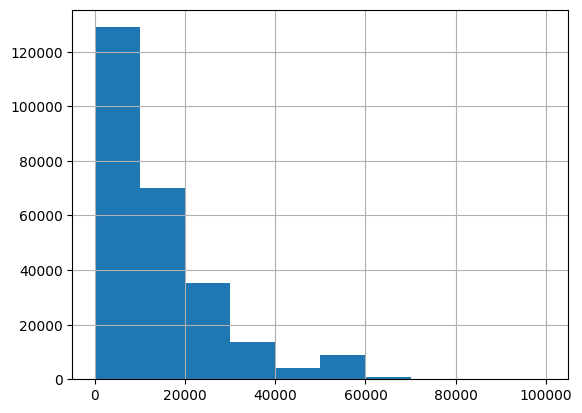

In [56]:
bpic12[bpic12['case:AMOUNT_REQ']>0]['case:AMOUNT_REQ'].hist()

In [83]:
accepted_offers = set(bpic12[(bpic12['concept:name']=='ACCEPTED') & (bpic12['EventOrigin']=='O')]['case:concept:name'].unique())
declined_offers = set(bpic12[(bpic12['concept:name']=='DECLINED') & (bpic12['EventOrigin']=='O')]['case:concept:name'].unique())
check_this = set(bpic12['case:concept:name'].unique()).difference(accepted_offers.union(declined_offers))
bpic12[(bpic12['case:concept:name'].isin(check_this)) & (bpic12['concept:name'].isin(['ACCEPTED','DECLINED']))].sort_values(['case:concept:name','time:timestamp'],ascending=True)[['case:concept:name','concept:name','EventOrigin']]

case:concept:name concept:name EventOrigin
126               173697     DECLINED           A
129               173700     DECLINED           A
151               173706     DECLINED           A
333               173724     DECLINED           A
337               173727     DECLINED           A
...                  ...          ...         ...
262146            214364     ACCEPTED           A
262170            214367     DECLINED           A
262175            214370     DECLINED           A
262185            214373     ACCEPTED           A
262198            214376     DECLINED           A

[8901 rows x 3 columns]

In [111]:
bpic12_eo = bpic12[['case:concept:name','EventOrigin','time:timestamp','lifecycle:transition']].sort_values(['case:concept:name','EventOrigin'])
bpic12_eo.rename({'EventOrigin':'concept:name'},axis=1,inplace=True)
dcr_eo1, la = alg.apply(bpic12_eo, alg.DCR_BASIC,timed=True)
dcr_exporter.apply(dcr_eo1,path="models/bpi12_event_origin.xml",dcr_title="",dcr_description="")

/home/vco/Projects/pm4py-dcr/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [112]:
bpic12[bpic12['case:concept:name']=='173688'].sort_values('time:timestamp', ascending=True)[['concept:name','EventOrigin','org:resource','lifecycle:transition','time:timestamp']]

concept:name EventOrigin org:resource lifecycle:transition  \
0              SUBMITTED           A          112             COMPLETE   
1        PARTLYSUBMITTED           A          112             COMPLETE   
2            PREACCEPTED           A          112             COMPLETE   
3   Completeren aanvraag           W          112             SCHEDULE   
4   Completeren aanvraag           W          NaN                START   
5               ACCEPTED           A        10862             COMPLETE   
6               SELECTED           O        10862             COMPLETE   
7              FINALIZED           A        10862             COMPLETE   
8                CREATED           O        10862             COMPLETE   
9                   SENT           O        10862             COMPLETE   
10     Nabellen offertes           W          NaN             SCHEDULE   
11  Completeren aanvraag           W          NaN             COMPLETE   
12     Nabellen offertes           W          NaN                START   
13     Nabellen offertes           W          NaN             COMPLETE   
14     Nabellen offertes           W        10913                START   
15     Nabellen offertes           W        10913             COMPLETE   
16     Nabellen offertes           W        11049                START   
17                  SENT           O        11049             COMPLETE   
18    Valideren aanvraag           W        11049             SCHEDULE   
19     Nabellen offertes           W        11049             COMPLETE   
20    Valideren aanvraag           W        10629                START   
21            REGISTERED           A        10629             COMPLETE   
22              APPROVED           A        10629             COMPLETE   
23              ACCEPTED           O        10629             COMPLETE   
24             ACTIVATED           A        10629             COMPLETE   
25    Valideren aanvraag           W        10629             COMPLETE   

                     time:timestamp  
0  2011-09-30 22:38:44.546000+00:00  
1  2011-09-30 22:38:44.880000+00:00  
2  2011-09-30 22:39:37.906000+00:00  
3  2011-09-30 22:39:38.875000+00:00  
4  2011-10-01 09:36:46.437000+00:00  
5  2011-10-01 09:42:43.308000+00:00  
6  2011-10-01 09:45:09.243000+00:00  
7  2011-10-01 09:45:09.243000+00:00  
8  2011-10-01 09:45:11.197000+00:00  
9  2011-10-01 09:45:11.380000+00:00  
10 2011-10-01 09:45:11.554000+00:00  
11 2011-10-01 09:45:13.917000+00:00  
12 2011-10-01 10:15:41.290000+00:00  
13 2011-10-01 10:17:08.924000+00:00  
14 2011-10-08 14:26:57.720000+00:00  
15 2011-10-08 14:32:00.886000+00:00  
16 2011-10-10 09:32:22.495000+00:00  
17 2011-10-10 09:33:03.668000+00:00  
18 2011-10-10 09:33:04.560000+00:00  
19 2011-10-10 09:33:05.791000+00:00  
20 2011-10-13 08:05:26.925000+00:00  
21 2011-10-13 08:37:29.226000+00:00  
22 2011-10-13 08:37:29.226000+00:00  
23 2011-10-13 08:37:29.226000+00:00  
24 2011-10-13 08:37:29.226000+00:00  
25 2011-10-13 08:37:37.026000+00:00

In [58]:
bpic12[['EventOrigin','org:resource','concept:name']].groupby(['EventOrigin','org:resource','concept:name']).all()

Empty DataFrame
Columns: []
Index: [(A, 10138, ACCEPTED), (A, 10138, ACTIVATED), (A, 10138, APPROVED), (A, 10138, CANCELLED), (A, 10138, DECLINED), (A, 10138, FINALIZED), (A, 10138, PREACCEPTED), (A, 10138, REGISTERED), (A, 10188, DECLINED), (A, 10228, ACCEPTED), (A, 10228, CANCELLED), (A, 10228, DECLINED), (A, 10228, FINALIZED), (A, 10228, PREACCEPTED), (A, 10609, ACCEPTED), (A, 10609, ACTIVATED), (A, 10609, APPROVED), (A, 10609, CANCELLED), (A, 10609, DECLINED), (A, 10609, FINALIZED), (A, 10609, PREACCEPTED), (A, 10609, REGISTERED), (A, 10629, ACCEPTED), (A, 10629, ACTIVATED), (A, 10629, APPROVED), (A, 10629, CANCELLED), (A, 10629, DECLINED), (A, 10629, FINALIZED), (A, 10629, PREACCEPTED), (A, 10629, REGISTERED), (A, 10779, ACCEPTED), (A, 10779, ACTIVATED), (A, 10779, APPROVED), (A, 10779, CANCELLED), (A, 10779, DECLINED), (A, 10779, FINALIZED), (A, 10779, REGISTERED), (A, 10789, CANCELLED), (A, 10809, ACCEPTED), (A, 10809, ACTIVATED), (A, 10809, APPROVED), (A, 10809, CANCELLED), (A, 10809, DECLINED), (A, 10809, FINALIZED), (A, 10809, PREACCEPTED), (A, 10809, REGISTERED), (A, 10859, ACCEPTED), (A, 10859, CANCELLED), (A, 10859, DECLINED), (A, 10859, FINALIZED), (A, 10859, PREACCEPTED), (A, 10861, ACCEPTED), (A, 10861, CANCELLED), (A, 10861, DECLINED), (A, 10861, FINALIZED), (A, 10861, PREACCEPTED), (A, 10862, ACCEPTED), (A, 10862, CANCELLED), (A, 10862, DECLINED), (A, 10862, FINALIZED), (A, 10862, PREACCEPTED), (A, 10863, ACCEPTED), (A, 10863, CANCELLED), (A, 10863, DECLINED), (A, 10863, FINALIZED), (A, 10863, PREACCEPTED), (A, 10880, ACCEPTED), (A, 10880, CANCELLED), (A, 10880, DECLINED), (A, 10880, FINALIZED), (A, 10880, PREACCEPTED), (A, 10881, ACCEPTED), (A, 10881, CANCELLED), (A, 10881, DECLINED), (A, 10881, FINALIZED), (A, 10881, PREACCEPTED), (A, 10889, ACCEPTED), (A, 10889, CANCELLED), (A, 10889, DECLINED), (A, 10889, FINALIZED), (A, 10889, PREACCEPTED), (A, 10899, CANCELLED), (A, 10909, ACCEPTED), (A, 10909, CANCELLED), (A, 10909, DECLINED), (A, 10909, FINALIZED), (A, 10909, PREACCEPTED), (A, 10910, ACCEPTED), (A, 10910, CANCELLED), (A, 10910, DECLINED), (A, 10910, FINALIZED), (A, 10910, PREACCEPTED), (A, 10912, ACCEPTED), (A, 10912, CANCELLED), (A, 10912, DECLINED), (A, 10912, FINALIZED), (A, 10912, PREACCEPTED), (A, 10913, ACCEPTED), (A, 10913, CANCELLED), (A, 10913, DECLINED), ...]

[871 rows x 0 columns]

# BPIC 12 TKDE (seems to be the same as BPIC 12)

In [36]:
tkde_bpic12 = pm4py.read_xes('/home/vco/Datasets/data/TKDE_Benchmark/BPIC12.xes')

parsing log, completed traces :: 100%|██████████| 13087/13087 [00:06<00:00, 1907.18it/s]


# BPIC 17

In [16]:
bpic17 = pm4py.read_xes('/home/vco/Datasets/BPI Challenge 2017.xes')
print(bpic17['EventOrigin'].unique())
pm4py.write_xes(bpic17[bpic17['EventOrigin']=='Application'],file_path='datasets/bpic17_application')
pm4py.write_xes(bpic17[bpic17['EventOrigin']=='Offer'],file_path='datasets/bpic17_offer')
pm4py.write_xes(bpic17[bpic17['EventOrigin']=='Workflow'],file_path='datasets/bpic17_workflow')
pm4py.write_xes(bpic17,file_path='datasets/bpic17_all')

array(['Application', 'Workflow', 'Offer'], dtype=object)

In [23]:
bpic17[['EventOrigin','org:resource','concept:name']].groupby(['EventOrigin','org:resource','concept:name']).first()

Empty DataFrame
Columns: []
Index: [(Application, User_1, A_Cancelled), (Application, User_1, A_Concept), (Application, User_1, A_Create Application), (Application, User_1, A_Submitted), (Application, User_10, A_Accepted), (Application, User_10, A_Cancelled), (Application, User_10, A_Complete), (Application, User_10, A_Concept), (Application, User_10, A_Create Application), (Application, User_10, A_Denied), (Application, User_10, A_Incomplete), (Application, User_10, A_Validating), (Application, User_100, A_Accepted), (Application, User_100, A_Complete), (Application, User_100, A_Concept), (Application, User_100, A_Create Application), (Application, User_100, A_Denied), (Application, User_100, A_Incomplete), (Application, User_100, A_Pending), (Application, User_100, A_Validating), (Application, User_101, A_Accepted), (Application, User_101, A_Complete), (Application, User_101, A_Concept), (Application, User_101, A_Create Application), (Application, User_101, A_Denied), (Application, User_101, A_Incomplete), (Application, User_101, A_Validating), (Application, User_102, A_Accepted), (Application, User_102, A_Cancelled), (Application, User_102, A_Complete), (Application, User_102, A_Concept), (Application, User_102, A_Create Application), (Application, User_102, A_Denied), (Application, User_102, A_Incomplete), (Application, User_102, A_Pending), (Application, User_102, A_Validating), (Application, User_103, A_Accepted), (Application, User_103, A_Cancelled), (Application, User_103, A_Complete), (Application, User_103, A_Concept), (Application, User_103, A_Create Application), (Application, User_103, A_Validating), (Application, User_104, A_Accepted), (Application, User_104, A_Cancelled), (Application, User_104, A_Complete), (Application, User_104, A_Concept), (Application, User_104, A_Create Application), (Application, User_105, A_Accepted), (Application, User_105, A_Cancelled), (Application, User_105, A_Complete), (Application, User_105, A_Concept), (Application, User_105, A_Create Application), (Application, User_105, A_Incomplete), (Application, User_105, A_Validating), (Application, User_106, A_Accepted), (Application, User_106, A_Complete), (Application, User_106, A_Concept), (Application, User_106, A_Create Application), (Application, User_106, A_Denied), (Application, User_106, A_Incomplete), (Application, User_106, A_Pending), (Application, User_106, A_Validating), (Application, User_107, A_Accepted), (Application, User_107, A_Cancelled), (Application, User_107, A_Complete), (Application, User_107, A_Concept), (Application, User_107, A_Create Application), (Application, User_107, A_Denied), (Application, User_107, A_Incomplete), (Application, User_107, A_Pending), (Application, User_107, A_Validating), (Application, User_108, A_Accepted), (Application, User_108, A_Complete), (Application, User_108, A_Concept), (Application, User_108, A_Create Application), (Application, User_109, A_Accepted), (Application, User_109, A_Cancelled), (Application, User_109, A_Complete), (Application, User_109, A_Concept), (Application, User_109, A_Create Application), (Application, User_109, A_Denied), (Application, User_109, A_Incomplete), (Application, User_109, A_Pending), (Application, User_109, A_Validating), (Application, User_11, A_Accepted), (Application, User_11, A_Cancelled), (Application, User_11, A_Complete), (Application, User_11, A_Concept), (Application, User_11, A_Create Application), (Application, User_11, A_Denied), (Application, User_11, A_Incomplete), (Application, User_11, A_Validating), (Application, User_110, A_Accepted), (Application, User_110, A_Cancelled), (Application, User_110, A_Complete), (Application, User_110, A_Concept), (Application, User_110, A_Create Application), (Application, User_111, A_Accepted), (Application, User_111, A_Cancelled), (Application, User_111, A_Complete), ...]

[2414 rows x 0 columns]

# BPIC 17 - Just the Offers (Offer log)

In [17]:
bpic17_offer = pm4py.read_xes('/home/vco/Datasets/BPI Challenge 2017 - Offer log.xes')
print(bpic17_offer['EventOrigin'].unique())

array(['Offer'], dtype=object)

# BPIC 17 - f - TKDE - used by the imperative miners

In [18]:
bpic17_f = pm4py.read_xes('/home/vco/Datasets/data/TKDE_Benchmark/BPIC17_f.xes')
print(bpic17_f['EventOrigin'].unique())

array(['Application', 'Offer', 'Workflow'], dtype=object)

In [ ]:
accepted_offers = set(bpic12[(bpic12['concept:name']=='ACCEPTED') & (bpic12['EventOrigin']=='O')]['case:concept:name'].unique())
declined_offers = set(bpic12[(bpic12['concept:name']=='DECLINED') & (bpic12['EventOrigin']=='O')]['case:concept:name'].unique())
check_this = set(bpic12['case:concept:name'].unique()).difference(accepted_offers.union(declined_offers))
bpic12[(bpic12['case:concept:name'].isin(check_this)) & (bpic12['concept:name'].isin(['ACCEPTED','DECLINED']))].sort_values(['case:concept:name','time:timestamp'],ascending=True)[['case:concept:name','concept:name','EventOrigin']]

In [109]:
bpic17_eo = bpic17[['case:concept:name', 'EventOrigin', 'time:timestamp', 'lifecycle:transition']].sort_values(
    ['case:concept:name', 'EventOrigin'])
bpic17_eo.rename({'EventOrigin': 'concept:name'}, axis=1, inplace=True)
dcr_eo17, la17 = alg.apply(bpic17_eo, alg.DCR_BASIC,timed=True)
dcr_exporter.apply(dcr_eo17, path="models/bpi17_event_origin.xml", dcr_title="", dcr_description="")

/home/vco/Projects/pm4py-dcr/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


# Playground stuff from notebook 7

In [ ]:
#test trace to test timings
cids = [1,1,1,1,1,1,
        2,2,2,2,2,
        3,3,3,3,3,3,3,3,3,3,
        4,4,4,4,4,4,4,4,4,4,4,4,4,4,4]
events = ['B','B','C','D','E','F',
          'A', 'B', 'E', 'F' ,'C',
          'A', 'B', 'F', 'C', 'B', 'C', 'B', 'E', 'F', 'C',
          'B','B','B','Z','B','C','B','A','C','Z','C','C','B','B','C']
timestamps = [pd.to_datetime('2021-8-02'),pd.to_datetime('2021-10-02'),pd.to_datetime('2021-10-03'),
                      pd.to_datetime('2021-10-04'),pd.to_datetime('2021-10-05'),pd.to_datetime('2021-10-06'),
                     pd.to_datetime('2021-10-01'),pd.to_datetime('2021-10-02'),pd.to_datetime('2021-10-03'),
                      pd.to_datetime('2021-10-04'),pd.to_datetime('2021-10-05'),
                     pd.to_datetime('2021-10-01'),pd.to_datetime('2021-10-02'),pd.to_datetime('2021-10-03'),
                      pd.to_datetime('2021-10-04'),pd.to_datetime('2021-10-05'),pd.to_datetime('2021-10-06'),pd.to_datetime('2021-10-07'),
                      pd.to_datetime('2021-10-08'),pd.to_datetime('2021-10-09'),pd.to_datetime('2021-10-10'),
                     pd.to_datetime('2021-9-01'),pd.to_datetime('2021-10-01'),pd.to_datetime('2021-10-03'),
                      pd.to_datetime('2021-10-04'),pd.to_datetime('2021-10-05'),pd.to_datetime('2021-10-06'),
                      pd.to_datetime('2021-10-07'),pd.to_datetime('2021-10-08'),pd.to_datetime('2021-10-09'),
                      pd.to_datetime('2021-10-10'),pd.to_datetime('2021-10-11'),pd.to_datetime('2025-10-11'),
                      pd.to_datetime('2025-10-12'),pd.to_datetime('2025-10-13'),pd.to_datetime('2025-10-14')]
test_log_dict = {
    'case:concept:name':cids,
    'concept:name':events,
    'time:timestamp':timestamps
}

test_tid = {
    'CONDITION': [['B','C']],
    'RESPONSE': [['B','C']]
}

test_log_df = pd.DataFrame(test_log_dict)
test_event_log = deepcopy(test_log_df)

In [10]:
#test traces for subproceses
dict_keys = ['case:concept:name','concept:name','time:timestamp']

def create_test_traces(ordered_event_matrix):
    start_date = dt.date(2023,1,1)
    case_id = 1
    test_el = []
    for i, trace in enumerate(ordered_event_matrix):
        date = start_date
        for j, event in enumerate(trace):
            test_el.append({dict_keys[0]:str(case_id),dict_keys[1]:str(event),dict_keys[2]:date})
            date = date + dt.timedelta(days=np.random.randint(1, 10)) # TODO: there could be a random sample from a distribution here
        case_id = case_id + 1
    df_test = pd.DataFrame(test_el,columns=['case:concept:name','concept:name','time:timestamp'],dtype=str)
    df_test['time:timestamp'] = pd.to_datetime(df_test['time:timestamp'])
    return pm4py.convert_to_event_log(df_test)

def create_test_traces_with_dates(ordered_event_matrix, ordered_dates_matrix):
    case_id = 1
    test_el = []
    for i, trace in enumerate(ordered_event_matrix):
        for j, event in enumerate(trace):
            date = pd.to_datetime(ordered_dates_matrix[i][j])
            test_el.append({dict_keys[0]:str(case_id),dict_keys[1]:str(event),dict_keys[2]:date})
        case_id = case_id + 1
    df_test = pd.DataFrame(test_el,columns=['case:concept:name','concept:name','time:timestamp'],dtype=str)
    df_test['time:timestamp'] = pd.to_datetime(df_test['time:timestamp'])
    return pm4py.convert_to_event_log(df_test)

In [ ]:
A,B,C,D,E,F = 'A','B','C','D','E','F'
event_log = create_test_traces([[A,C,C,B,D],[A,B,C,C,D],[A,E,F,D],[A,F,E,D],[A,B,C,D,A,E,F,D],[A,C,B,C,D,A,F,E,D]])

# Choose your doctor trace

In [5]:
A,B,C,D = 'System Choose doctor','Citizen Choose doctor','Family Doctor 1','Family Doctor 2'
E = 'Consent to transfer medical history'
F = 'Transfer medical history'
G = 'Send mail to citizen'
events = [[A,C,G,E,F],
          [A,D,G,E,F],
          [B,E,C,F],
          [B,E,D,F]]
dates = [['2023-01-01','2023-01-08','2023-01-09','2023-01-10','2023-01-11'],
         ['2023-01-01','2023-01-08','2023-01-09','2023-04-01','2023-04-02'],
         ['2023-01-01','2023-01-02','2023-01-04','2023-01-05'],
         ['2023-01-01','2023-01-06','2023-01-07','2023-01-08']]
running_example_trace = create_test_traces_with_dates(events,dates)
tt = pm4py.convert_to_event_log(running_example_trace)
pm4py.write_xes(tt,file_path='/home/vco/Projects/pm4py-dcr/models/running_example_trace_doctor.xes')

/home/vco/Projects/pm4py-dcr/pm4py/utils.py:494: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


exporting log, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
pm4py.convert_to_dataframe(tt)

concept:name            time:timestamp  \
0                  System Choose doctor 2023-01-01 00:00:00+00:00   
1                       Family Doctor 1 2023-01-08 00:00:00+00:00   
2                  Send mail to citizen 2023-01-09 00:00:00+00:00   
3   Consent to transfer medical history 2023-01-10 00:00:00+00:00   
4              Transfer medical history 2023-01-11 00:00:00+00:00   
5                  System Choose doctor 2023-01-01 00:00:00+00:00   
6                       Family Doctor 2 2023-01-08 00:00:00+00:00   
7                  Send mail to citizen 2023-01-09 00:00:00+00:00   
8   Consent to transfer medical history 2023-04-01 00:00:00+00:00   
9              Transfer medical history 2023-04-02 00:00:00+00:00   
10                Citizen Choose doctor 2023-01-01 00:00:00+00:00   
11  Consent to transfer medical history 2023-01-02 00:00:00+00:00   
12                      Family Doctor 1 2023-01-04 00:00:00+00:00   
13             Transfer medical history 2023-01-05 00:00:00+00:00   
14                Citizen Choose doctor 2023-01-01 00:00:00+00:00   
15  Consent to transfer medical history 2023-01-06 00:00:00+00:00   
16                      Family Doctor 2 2023-01-07 00:00:00+00:00   
17             Transfer medical history 2023-01-08 00:00:00+00:00   

   case:concept:name  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  
5                  2  
6                  2  
7                  2  
8                  2  
9                  2  
10                 3  
11                 3  
12                 3  
13                 3  
14                 4  
15                 4  
16                 4  
17                 4

# I1 I2 F1 F2 example

In [64]:
A,B,C,D = 'I1','I2','F1','F2'
running_example_trace = create_test_traces([[A,C],[A,D],[B,C],[B,D]])
tt = pm4py.convert_to_event_log(running_example_trace)
pm4py.write_xes(tt,file_path='/home/vco/Downloads/running_example_trace.xes')

/home/vco/Projects/pm4py-dcr/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


2023-01-08
2023-01-11
2023-01-08
2023-01-15
2023-01-02
2023-01-05
2023-01-04
2023-01-10


exporting log, completed traces :: 100%|██████████| 4/4 [00:00<00:00, 23109.11it/s]


In [7]:
running_example_trace

[{'attributes': {'concept:name': '1'}, 'events': [{'concept:name': 'System Choose doctor', 'time:timestamp': Timestamp('2023-01-01 00:00:00'), 'case:concept:name': '1'}, '..', {'concept:name': 'Transfer medical history', 'time:timestamp': Timestamp('2023-01-11 00:00:00'), 'case:concept:name': '1'}]}, '....', {'attributes': {'concept:name': '4'}, 'events': [{'concept:name': 'Citizen Choose doctor', 'time:timestamp': Timestamp('2023-01-01 00:00:00'), 'case:concept:name': '4'}, '..', {'concept:name': 'Transfer medical history', 'time:timestamp': Timestamp('2023-01-08 00:00:00'), 'case:concept:name': '4'}]}]

In [15]:
configs = [{'variant': Variants.DCR_BASIC },{ 'variant': Variants.DCR_ME },{'variant': Variants.DCR_N,},{'variant': Variants.DCR_NME,}]
dcrs = benchmark_event_log_from_configs(tt,dcr_title="running_example",result_file_prefix="running_example_doctor",configs=configs)

[i] Started with config: {'variant': <Variants.DCR_BASIC: <module 'pm4py.algo.discovery.dcr_discover.variants.dcr_discover' from '/home/vco/Projects/pm4py-dcr/pm4py/algo/discovery/dcr_discover/variants/dcr_discover.py'>>}
[i] Mining with basic DisCoveR
[!] Model saved in models/running_example_doctor__config0.xml
[i] Started with config: {'variant': <Variants.DCR_ME: <module 'pm4py.algo.discovery.dcr_discover.extenstions.mutual_exclusion' from '/home/vco/Projects/pm4py-dcr/pm4py/algo/discovery/dcr_discover/extenstions/mutual_exclusion.py'>>}
[i] Mining with ME-DisCoveR
[!] Model saved in models/running_example_doctor__config1.xml
[i] Started with config: {'variant': <Variants.DCR_N: <module 'pm4py.algo.discovery.dcr_discover.extenstions.nesting' from '/home/vco/Projects/pm4py-dcr/pm4py/algo/discovery/dcr_discover/extenstions/nesting.py'>>}
[i] Mining with N-DisCoveR
[!] Model saved in models/running_example_doctor__config2.xml
[i] Started with config: {'variant': <Variants.DCR_NME: [<m

In [16]:
dcrs[3]

{'events': {'Citizen Choose doctor',
  'Consent to transfer medical history',
  'Family Doctor 1',
  'Family Doctor 2',
  'ME0',
  'ME1',
  'N1',
  'N2',
  'N3',
  'N4',
  'Send mail to citizen',
  'System Choose doctor',
  'Transfer medical history'},
 'conditionsFor': {'Transfer medical history': {'Consent to transfer medical history'},
  'Consent to transfer medical history': {'N3', 'Send mail to citizen'},
  'Send mail to citizen': {'N1'},
  'N1': {'N3'}},
 'milestonesFor': {},
 'responseTo': {'System Choose doctor': {'Send mail to citizen'},
  'Consent to transfer medical history': {'Transfer medical history'},
  'Send mail to citizen': {'Consent to transfer medical history'},
  'Citizen Choose doctor': {'Consent to transfer medical history'},
  'N1': {'Transfer medical history'}},
 'noResponseTo': {},
 'includesTo': {},
 'excludesTo': {'Transfer medical history': {'Transfer medical history'},
  'Consent to transfer medical history': {'Consent to transfer medical history'},
  'Sen

In [1]:
def get_mutual_exclusions(dcr, i=0):
    """
    Get subprocesses based on cliques. Now we naively get the largest clique.
    TODO: Get cliques smartly by taking the cliques that jointly use the highest number of events.
    It should be solved as a search space problem.
    Parameters
    ----------
    dcr
    i

    Returns
    -------

    """

    graph = get_mutually_excluding_graph(dcr)
    cliques = list(frozenset(s) for s in nx.enumerate_all_cliques(graph) if len(s) > 1)
    cliques = sorted(cliques, key=len, reverse=True)
    sps = {}
    used_cliques = {}
    for c in cliques:
        used_cliques[c] = False

    used_events = set()
    for clique in cliques:
        if not used_cliques[clique]:
            if len(clique.intersection(used_events)) == 0:
                # any new mutually exclusive subprocess must be disjoint from all existing ones
                sps[f'ME{i}'] = clique
                i += 1
                used_cliques[clique] = True
                used_events = used_events.union(clique)
    return sps


def get_mutually_excluding_graph(dcr):
    rel_matrices = {}
    for rel in ['excludesTo']:
        ind = pd.Index(sorted(dcr['events']), dtype=str)
        rel_matrix = pd.DataFrame(0, columns=ind, index=ind, dtype=int)
        for e in dcr['events']:
            for e_prime in dcr['events']:
                if e in dcr[rel] and e_prime in dcr[rel][e]:
                    rel_matrix.at[e, e_prime] = 1
        rel_matrices[rel] = rel_matrix

    self_excluding = set()
    for e in dcr['events']:
        if rel_matrices['excludesTo'].at[e, e] == 1:
            self_excluding.add(e)
    mutually_excluding = []
    for e in self_excluding:
        for e_prime in self_excluding:
            if e != e_prime and \
                    rel_matrices['excludesTo'].at[e, e_prime] == 1 and \
                    rel_matrices['excludesTo'].at[e_prime, e] == 1:
                if (e, e_prime) not in mutually_excluding and (e_prime, e) not in mutually_excluding:
                    mutually_excluding.append((e, e_prime))

    return nx.from_edgelist(mutually_excluding)

In [12]:
def get_mutual_exclusions2(dcr, i=0):
    """
    Get subprocesses based on cliques. Now we naively get the largest clique.
    TODO: Get cliques smartly by taking the cliques that jointly use the highest number of events.
    It should be solved as a search space problem.
    Parameters
    ----------
    dcr
    i

    Returns
    -------

    """

    graph = get_mutually_excluding_graph2(dcr)
    cliques = list(frozenset(s) for s in nx.enumerate_all_cliques(graph) if len(s) > 1)
    cliques = sorted(cliques, key=len, reverse=True)
    sps = {}

    used_events = set()
    for clique in cliques:
        if len(clique.intersection(used_events)) == 0:
            # any new mutually exclusive subprocess must be disjoint from all existing ones
            sps[f'ME{i}'] = clique
            i += 1
            used_events = used_events.union(clique)
    return sps


def get_mutually_excluding_graph2(dcr):
    self_excluded = set()
    for e in dcr['events']:
        if e in dcr['excludesTo'] and e in dcr['excludesTo'][e]:
            self_excluded.add(e)
    visited = set()
    mutually_excluded = set()
    for e in self_excluded:
        for e_prime in self_excluded.difference(visited):
            if e != e_prime and (e in dcr['excludesTo'] and e_prime in dcr['excludesTo'][e]) or (e_prime in dcr['excludesTo'] and e in dcr['excludesTo'][e_prime]):
                mutually_excluded.add((e,e_prime))
            visited.add(e)

    return nx.from_edgelist(mutually_excluded)

In [3]:
config = [{'variant': Variants.DCR_BASIC }]

In [4]:
event_log_file = '/home/vco/Datasets/Sepsis Cases - Event Log.xes'
dcr_title = 'Sepsis Cases'
result_file_prefix = 'sepsis'

sepsis_dcrs = benchmark_event_log_from_configs(event_log_file,result_file_prefix,dcr_title,config)

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

[i] Started with config: {'variant': <Variants.DCR_BASIC: <module 'pm4py.algo.discovery.dcr_discover.variants.dcr_discover' from '/home/vco/Projects/pm4py-dcr/pm4py/algo/discovery/dcr_discover/variants/dcr_discover.py'>>}
[i] Mining with basic DisCoveR
[!] Model saved in models/sepsis__config0.xml


In [7]:
dcr = sepsis_dcrs[0]

In [14]:
get_mutual_exclusions(dcr)

{'ME0': frozenset({'Release A',
            'Release B',
            'Release C',
            'Release D',
            'Release E'})}

In [15]:
get_mutual_exclusions2(dcr)

{'ME0': frozenset({'Release A',
            'Release B',
            'Release C',
            'Release D',
            'Release E'})}

In [17]:
from math import comb

In [34]:
n = 6
n + n*(n-1) - 1

35